<a href="https://colab.research.google.com/github/MihaiDogariu/Keysight-Deep-Learning-Fundamentals--v2-/blob/main/scripts/Unit_8_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression

This notebook addresses the problem of regression: having a set of explanatory variables, we are interested to see if we can connect a dependent variable to them. In other words we want to predict one of the object's attributes based on the values of the rest of its attributes.

This application aims to predict the fuel consumption of a set of cars, based on several other indicators.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import torch
from torch import nn

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

Download and inspect the dataset

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
raw_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Auxiliary function to help with transforming from 'miles per gallon' to 'litres per 100 km'.

In [ ]:
def mpg_to_lper100km(mpg):
  gallon = 3.785411784 # 1 gallon = 3.785411784 litres
  mile = 1.609344 # 1 mile = 1.609344 km
  lper100km = 100 * (gallon / mile) / mpg
  return lper100km

Apply the above transformation on the entire dataset.

In [ ]:
dataset = raw_dataset.rename(columns={"MPG": "Consumption"})
dataset["Consumption"] = dataset["Consumption"].apply(lambda x: mpg_to_lper100km(x))
dataset

,Consumption,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,13.067477,8,307.0,130.0,3504.0,12.0,70,1
1,15.680972,8,350.0,165.0,3693.0,11.5,70,1
2,13.067477,8,318.0,150.0,3436.0,11.0,70,1
3,14.700911,8,304.0,150.0,3433.0,12.0,70,1
4,13.836152,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,8.711651,4,140.0,86.0,2790.0,15.6,82,1
394,5.345786,4,97.0,52.0,2130.0,24.6,82,2
395,7.350456,4,135.0,84.0,2295.0,11.6,82,1
396,8.400521,4,120.0,79.0,2625.0,18.6,82,1


Let's see how the data is correlated throughout the dataset.

<Axes: >

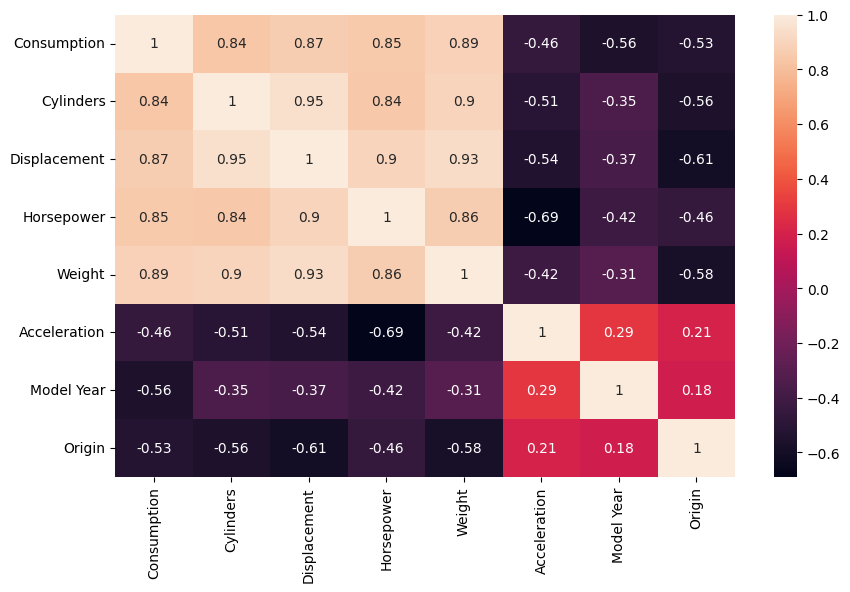

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(),annot=True,annot_kws={"size":10})

As it happens most of the time, the dataset might contain NULL or NaN values. We must find out if that also happens now.

In [ ]:
dataset.isna().sum()

Consumption     0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

We drop the NaN values since they represent only a tiny portion of the dataset. We plot the correlation matrix again, after dropping the features that do not hold a high enough correlation value with our w.

In [ ]:
dataset = dataset.dropna()

<Axes: >

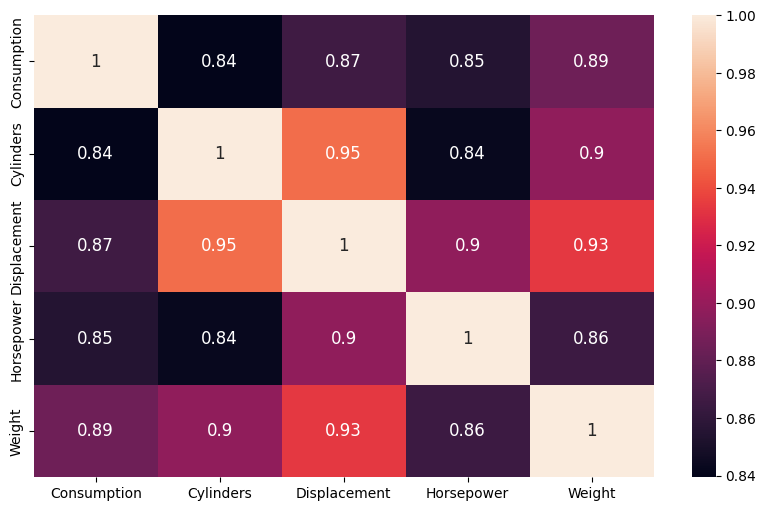

In [ ]:
dataset = dataset.drop(columns=["Acceleration", "Model Year", "Origin"])
plt.figure(figsize=(10,6))
sns.heatmap(dataset.corr(),annot=True,annot_kws={"size":12})

Let's plot some more info about the dataset.

In [ ]:
dataset.describe()

,Consumption,Cylinders,Displacement,Horsepower,Weight
count,392.000000,392.000000,392.000000,392.000000,392.000000
mean,11.248532,5.471939,194.411990,104.469388,2977.584184
std,3.913838,1.705783,104.644004,38.491160,849.402560
min,5.047523,3.000000,68.000000,46.000000,1613.000000
25%,8.110848,4.000000,105.000000,75.000000,2225.250000
50%,10.340351,4.000000,151.000000,93.500000,2803.500000
75%,13.836152,8.000000,275.750000,126.000000,3614.750000
max,26.134954,8.000000,455.000000,230.000000,5140.000000


(array([ 53., 102.,  67.,  71.,  30.,  36.,  26.,   4.,   2.,   1.]),
 array([ 5.048,  7.156,  9.265, 11.374, 13.482, 15.591, 17.7  , 19.809,
        21.917, 24.026, 26.135]),
 <BarContainer object of 10 artists>)

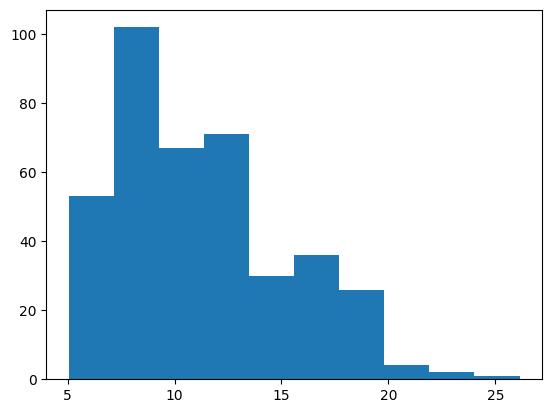

In [ ]:
plt.hist(dataset['Consumption'],histtype='bar')

We can see that there are quite a few outliers for the 'Horsepower' attribute

<Axes: >

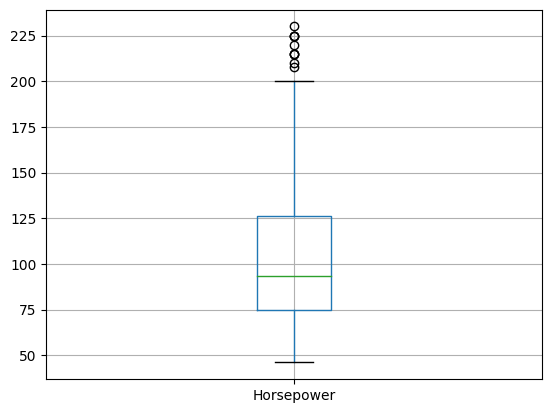

In [ ]:
dataset.boxplot(column="Horsepower")

Auxiliary function to detect outliers and help reduce the dataset only to the 25-75 quartile range.

In [ ]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        # Q1 = np.percentile(df[col], 25)
        Q1 = df[col].quantile(0.25)
        # 3rd quartile (75%)
        # Q3 = np.percentile(df[col],75)
        Q3 = df[col].quantile(0.75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

    return multiple_outliers

In [ ]:
drop = detect_outliers(dataset,0,['Consumption', 'Cylinders','Displacement','Horsepower','Weight'])
dataset = dataset.drop(drop, axis = 0).reset_index(drop=True)

In [ ]:
drop

[25, 26, 28, 6, 7, 8, 13, 27, 67, 94, 95, 116]

<Axes: >

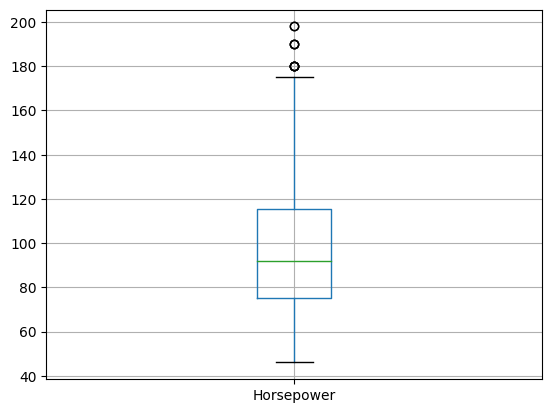

In [ ]:
dataset.boxplot(column="Horsepower")

<Axes: ylabel='Density'>

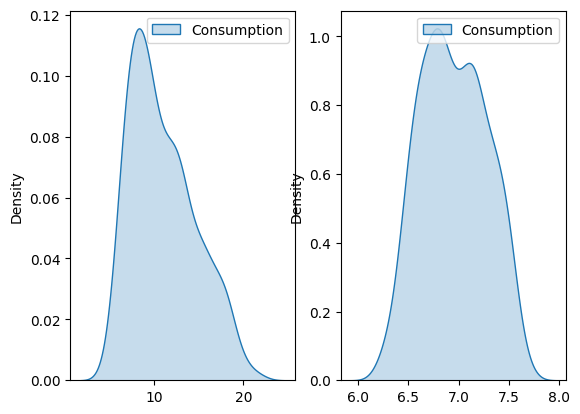

In [ ]:
log_dataset = dataset.copy()
log_dataset["Consumption"] = dataset["Consumption"].apply(lambda x: np.log(1 + 100*x))

f, axes = plt.subplots(1, 2)

sns.kdeplot(dataset[["Consumption"]], ax=axes[0], fill=True)
sns.kdeplot(log_dataset[["Consumption"]], ax=axes[1], fill=True)

Since the data seems to be skewed, we can use a transformation that will help straighten it up, such as the log transform.

In [ ]:
use_log_transform = True

if use_log_transform:
  dataset = log_dataset

Now that we are finally done with the data pre-processing, we can move on and train our network. First, we create the train-test subsets.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
train_features = train_dataset.drop(columns=["Consumption"])
train_labels = train_dataset["Consumption"]

test_dataset = dataset.drop(train_dataset.index)
test_features = test_dataset.drop(columns=["Consumption"])
test_labels = test_dataset["Consumption"]

We define the model architecture using the `torch.nn.Sequential()` approach.

In [ ]:
# Define network dimensions
n_input_dim = train_features.shape[1]
# Layer size
n_hidden = 10 # Number of hidden nodes
n_output = 1 # Number of output nodes for predicted consumption

# Build mdel
torch_model = torch.nn.Sequential(
    torch.nn.Linear(n_input_dim, n_hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden, n_output),
)

print(torch_model)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)


Defining the loss, learning rate and optimizer.

In [ ]:
loss_func = torch.nn.MSELoss() #Choosing mean square error as loss metric
learning_rate = 0.001
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)

Performing the actual training.

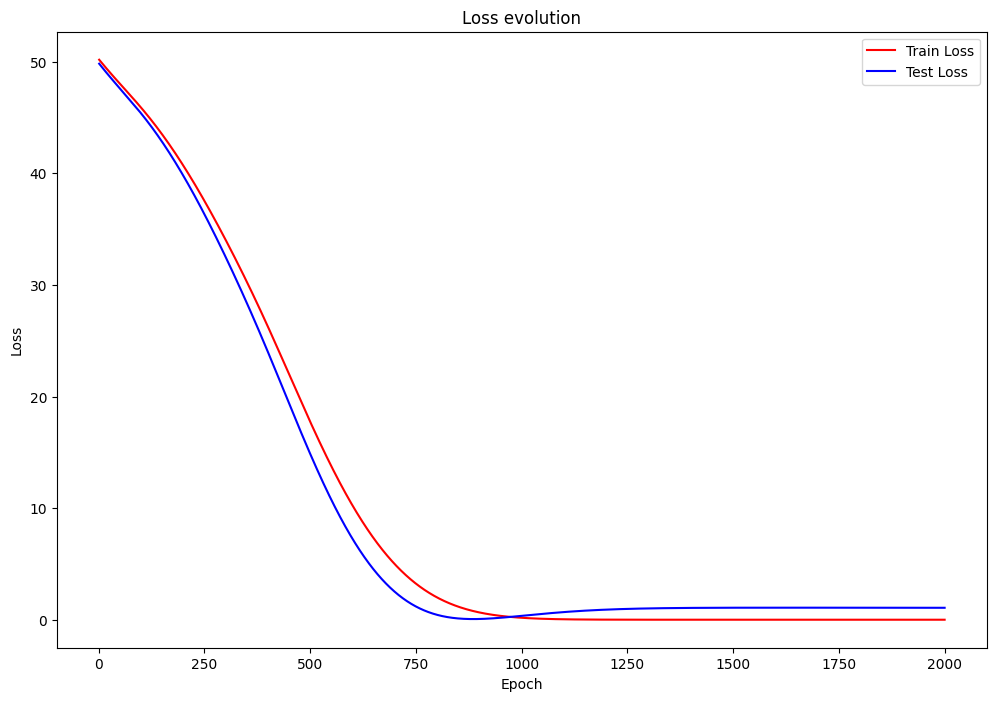

In [ ]:
train_error = []
test_error = []
iters = 2000

y_train_t = torch.FloatTensor(train_labels.values).reshape(-1,1) #Converting numpy array to torch tensor
x_train_t = torch.nn.functional.normalize(torch.FloatTensor(train_features.values), dim=0)

y_test_t = torch.FloatTensor(test_labels.values).reshape(-1,1) #Converting numpy array to torch tensor
x_test_t = torch.nn.functional.normalize(torch.FloatTensor(test_features.values), dim=0)

for i in range(iters):
    torch_model.train(True)
    # x_train_t = torch.FloatTensor(train_features.values)  #Converting numpy array to torch tensor
    y_train_hat = torch_model(x_train_t)
    # print(torch.transpose(y_hat, 0, 1))
    loss = loss_func(y_train_hat, y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_error.append(loss.item())

    torch_model.train(False)
    with torch.no_grad():
      y_test_hat = torch_model(x_test_t)
      test_loss = loss_func(y_test_hat, y_test_t)
      test_error.append(test_loss.item())


x = np.linspace(start=1, stop=iters, num=iters)
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(x, train_error, color="red", label="Train Loss")
ax.plot(x, test_error, color="blue", label="Test Loss")
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Loss evolution')
ax.legend()